In [1]:
import onnxruntime as ort
import numpy as np
import torch
from diffusers import DDPMScheduler
from transformers import CLIPTokenizer
from PIL import Image
import torch.nn.functional as F


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LATENT_SIZE = 16


# ============================================================
# Load ONNX sessions
# ============================================================

text_encoder_sess = ort.InferenceSession(
    "openvino_models/text_encoder.onnx",
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
)

unet_sess = ort.InferenceSession(
    "openvino_models/unet.onnx",
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
)

vae_sess = ort.InferenceSession(
    "openvino_models/vae_decoder.onnx",
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
)


# ============================================================
# Utility for running ONNX model
# ============================================================

def run_onnx(sess, inputs):
    io_binding = sess.io_binding()

    for name, arr in inputs.items():
        io_binding.bind_input(
            name,
            arr.device if hasattr(arr, "device") else "cpu",
            arr.dtype,
            arr.shape,
            arr
        )

    for output in sess.get_outputs():
        io_binding.bind_output(output.name)

    sess.run_with_iobinding(io_binding)
    outputs = io_binding.copy_outputs_to_cpu()
    return outputs


# ============================================================
# Main inference function
# ============================================================

def generate_image_onnx(prompt, steps=500, guidance=7.5):
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

    # -----------------------------
    # Encode text (prompt)
    # -----------------------------
    tokens = tokenizer(
        prompt,
        padding="max_length",
        truncation=True,
        max_length=77,
        return_tensors="pt"
    )

    uncond_tokens = tokenizer(
        "",
        padding="max_length",
        truncation=True,
        max_length=77,
        return_tensors="pt"
    )

    # Move to numpy
    ids = tokens["input_ids"].numpy()
    mask = tokens["attention_mask"].numpy()

    uncond_ids = uncond_tokens["input_ids"].numpy()
    uncond_mask = uncond_tokens["attention_mask"].numpy()

    # -----------------------------
    # Run ONNX Text Encoder
    # -----------------------------
    text_out = text_encoder_sess.run(
        None,
        {"input_ids": ids, "attention_mask": mask}
    )[0]

    uncond_out = text_encoder_sess.run(
        None,
        {"input_ids": uncond_ids, "attention_mask": uncond_mask}
    )[0]

    # Combined embeddings for classifier-free guidance
    context = np.concatenate([uncond_out, text_out], axis=0).astype(np.float32)

    # -----------------------------
    # Denoising Loop
    # -----------------------------
    scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")
    scheduler.set_timesteps(steps)

    latents = torch.randn((1, 4, LATENT_SIZE, LATENT_SIZE)).numpy().astype(np.float32)
    latents *= scheduler.init_noise_sigma

    for t in scheduler.timesteps:
        # duplicate latents for 2 batches (uncond + cond)
        latent_input = np.concatenate([latents, latents], axis=0).astype(np.float32)

        # ONNX UNet input
        unet_inputs = {
            "latent": latent_input.astype(np.float32),
            "timestep": np.array([t], dtype=np.float32),      # FIXED
            "context": context.astype(np.float32),
        }

        noise_pred = unet_sess.run(None, unet_inputs)[0]

        # CFG guidance
        uncond, cond = np.split(noise_pred, 2)
        guided = uncond + guidance * (cond - uncond)

        latents = scheduler.step(
            torch.from_numpy(guided),
            torch.tensor(t),
            torch.from_numpy(latents)
        ).prev_sample.numpy().astype(np.float32)

    # -----------------------------
    # Decode with VAE
    # -----------------------------
    latents = latents / 0.18215

    vae_out = vae_sess.run(
        None,
        {"latent": latents.astype(np.float32)}
    )[0]

    # -----------------------------
    # Convert to image
    # -----------------------------
    image = torch.tensor(vae_out)
    image = (image / 2 + 0.5).clamp(0, 1)

    image = image.permute(0, 2, 3, 1).squeeze(0).cpu().numpy()
    image = (image * 255).round().astype("uint8")

    return Image.fromarray(image)


*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:129 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, SUCCTYPE, const char*, const char*, int) [with ERRTYPE = cudaError; bool THRW = true; SUCCTYPE = cudaError; std::conditional_t<THRW, void, common::Status> = void] /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:121 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, SUCCTYPE, const char*, const char*, int) [with ERRTYPE = cudaError; bool THRW = true; SUCCTYPE = cudaError; std::conditional_t<THRW, void, common::Status> = void] CUDA failure 35: CUDA driver version is insufficient for CUDA runtime version ; GPU=-1 ; hostname=cs-01ka6ws6dt8djwgqyd33g9fn9j ; file=/onnxruntime_src/onnxruntime/core/providers/cuda/cuda_execution_provider.cc ; line=282 ; expr=cudaSetDevice(info_.device_id

/tmp/ipykernel_2827/2653955606.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(t),


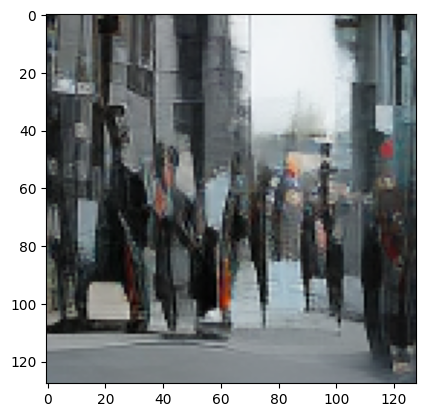

In [6]:
import matplotlib.pyplot as plt

img = generate_image_onnx("people walking on street")
plt.imshow(img)

In [3]:
import torch
from diffusers import UNet2DConditionModel, DDPMScheduler, AutoencoderKL
import numpy as np
import os

def debug_compare_unet(unet_pt, unet_onnx_sess):
    print("\n🔍 Running UNet ONNX vs PyTorch comparison test…")

    # ----------------------------------------------------------
    # 1. Create deterministic inputs
    # ----------------------------------------------------------
    torch.manual_seed(0)

    latent = torch.randn(2, 4, 16, 16).float().to(DEVICE)
    t = torch.tensor([50.0], dtype=torch.float32).to(DEVICE)
    context = torch.randn(2, 77, 512).float().to(DEVICE)

    # ----------------------------------------------------------
    # 2. PyTorch UNet output
    # ----------------------------------------------------------
    with torch.no_grad():
        pt_out = unet_pt(latent, t, context).sample.cpu().numpy()

    print("\n📌 PyTorch UNet output stats:")
    print(" mean =", pt_out.mean())
    print(" std  =", pt_out.std())
    print(" min  =", pt_out.min())
    print(" max  =", pt_out.max())

    # ----------------------------------------------------------
    # 3. ONNX UNet output
    # ----------------------------------------------------------
    latent_np = latent.cpu().numpy().astype(np.float32)
    t_np = t.cpu().numpy().astype(np.float32)
    context_np = context.cpu().numpy().astype(np.float32)

    onnx_out = unet_onnx_sess.run(
        None,
        {
            "latent": latent_np,
            "timestep": t_np,      # float32
            "context": context_np, # float32
        }
    )[0]

    print("\n📌 ONNX UNet output stats:")
    print(" mean =", onnx_out.mean())
    print(" std  =", onnx_out.std())
    print(" min  =", onnx_out.min())
    print(" max  =", onnx_out.max())

    # ----------------------------------------------------------
    # 4. L2 difference (should be VERY small)
    # ----------------------------------------------------------
    diff = np.abs(pt_out - onnx_out)
    print("\n🔧 Difference (PyTorch - ONNX):")
    print(" mean abs diff =", diff.mean())
    print(" max abs diff  =", diff.max())

    # ----------------------------------------------------------
    # 5. Verdict
    # ----------------------------------------------------------
    if diff.mean() < 1e-3:
        print("\n✅ UNet ONNX ≈ PyTorch (GOOD)")
    else:
        print("\n❌ UNet ONNX != PyTorch (BROKEN) — this is why images look psychedelic!")
        print("   → The error is inside your UNet export or timestep/context shapes.")
model_path = '/teamspace/studios/this_studio/Latent-Diffusion-Model-for-text-to-image-generation/ldm_checkpoints'
model_path = os.path.join(model_path, "epoch_11")
    
    # Initialize models
unet = UNet2DConditionModel.from_pretrained(
        os.path.join(model_path, "unet"),
        use_safetensors=True
    ).to(DEVICE)
checkpoint = torch.load(os.path.join(model_path, "training_state.pth"), map_location=DEVICE)
unet.load_state_dict(checkpoint['model_state_dict'])
debug_compare_unet(unet, unet_sess)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.



🔍 Running UNet ONNX vs PyTorch comparison test…

📌 PyTorch UNet output stats:
 mean = 0.0020395205
 std  = 0.5187144
 min  = -2.3936114
 max  = 1.9726732

📌 ONNX UNet output stats:
 mean = 0.00203953
 std  = 0.5187144
 min  = -2.39361
 max  = 1.9726714

🔧 Difference (PyTorch - ONNX):
 mean abs diff = 2.7294448e-07
 max abs diff  = 1.7881393e-06

✅ UNet ONNX ≈ PyTorch (GOOD)


In [4]:
from transformers import CLIPTokenizer, CLIPTextModel

def debug_compare_text_encoder(text_encoder_pt, text_encoder_onnx):
    print("\n🔍 Comparing Text Encoder (PyTorch vs ONNX)…")

    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

    tokens = tokenizer(
        ["a photo of a man walking"],
        padding="max_length",
        max_length=77,
        return_tensors="pt"
    ).to(DEVICE)

    input_ids = tokens["input_ids"]
    mask = tokens["attention_mask"]

    # PyTorch
    with torch.no_grad():
        pt_out = text_encoder_pt(input_ids)[0].cpu().numpy()

    # ONNX
    onnx_out = text_encoder_onnx.run(
        None,
        {"input_ids": input_ids.numpy(), "attention_mask": mask.numpy()}
    )[0]

    print("\n📌 PyTorch Text Encoder stats:")
    print(" mean =", pt_out.mean(), "std =", pt_out.std())

    print("\n📌 ONNX Text Encoder stats:")
    print(" mean =", onnx_out.mean(), "std =", onnx_out.std())

    diff = np.abs(pt_out - onnx_out)
    print("\n🔧 Difference:")
    print(" mean =", diff.mean(), "max =", diff.max())

    if diff.mean() < 1e-3:
        print("✅ Text Encoder OK")
    else:
        print("❌ TEXT ENCODER BROKEN — causes garbage diffusion output")

text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
debug_compare_text_encoder(text_encoder, text_encoder_sess)


🔍 Comparing Text Encoder (PyTorch vs ONNX)…

📌 PyTorch Text Encoder stats:
 mean = 0.12435255 std = 1.0981898

📌 ONNX Text Encoder stats:
 mean = 0.12363797 std = 1.0579273

🔧 Difference:
 mean = 0.5256294 max = 17.776976
❌ TEXT ENCODER BROKEN — causes garbage diffusion output


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(DEVICE)

def debug_compare_vae(vae_pt, vae_onnx_sess):
    print("\n🔍 Comparing VAE Decoder (PyTorch vs ONNX)…")

    torch.manual_seed(0)
    latent = torch.randn(1, 4, 16, 16).to(DEVICE)

    # PyTorch
    with torch.no_grad():
        pt_out = vae_pt.decode(latent).sample.cpu().numpy()

    # ONNX
    onnx_out = vae_onnx_sess.run(
        None,
        {"latent": latent.numpy().astype(np.float32)}
    )[0]

    print("\n📌 VAE PyTorch stats:")
    print(" mean =", pt_out.mean(), "std =", pt_out.std())

    print("\n📌 VAE ONNX stats:")
    print(" mean =", onnx_out.mean(), "std =", onnx_out.std())

    diff = np.abs(pt_out - onnx_out)
    print("\n🔧 Difference:")
    print(" mean =", diff.mean(), "max =", diff.max())

    if diff.mean() < 1e-3:
        print("✅ VAE Decoder OK")
    else:
        print("❌ VAE DECODER BROKEN — causes psychedelic output")
debug_compare_vae(vae, vae_sess)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.



🔍 Comparing VAE Decoder (PyTorch vs ONNX)…

📌 VAE PyTorch stats:
 mean = -0.08672454 std = 0.08719953

📌 VAE ONNX stats:
 mean = -0.08672448 std = 0.087199554

🔧 Difference:
 mean = 4.318423e-07 max = 1.1220574e-05
✅ VAE Decoder OK
